# Generating Fake Medical History for Aim 3 Regression

- Our three medical diagnoses we're checking for (ICD-9-CM / ICD-10-CM):
  1. Blood Cancers: (200–208 / C81–C96)
  1. Type 1 Diabetes: (250.x1 / E10)
  1. Pediatric Vasculitis: (287, 446 / D69, M30–31)

Consider also checking for respiratory outcomes. Even though this isn't the focus of our study, but we can check for this outcome as a quality check to make sure we at least find significance there.

In [1]:
# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
# local or gdrive
path_source = 'work'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data/joined_data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data/joined_data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data/joined_data'

In [3]:
# load full dataset
df = pd.read_parquet(os.path.join(data_path, 'joined_open_schools_only_10-10-22.parquet'))

In [4]:
# get every distinct month and zip code that we need health data for:
df.head(3)

,year,cdscode,school_county,school_zip,school_open_date,school_closed_date,school_lat,school_lon,school_wspd,school_elevation_m,...,new_year,open_close_dates_valid,Taxable Year,Zip Code,CA_AGI_per_returns,Total Tax Liability,school_county_v2,school_region_name,nearby_point_source_count,open_dates_valid
index,,,,,,,,,,,,,,,,,,,,,
0,2010.0,20102070109728,Madera,93610,2005-08-16,2014-06-30,37.115210,-120.26603,1.531352,70.84,...,2010-01-01,1,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,1.0,1
1,2010.0,20102072030187,Madera,93610,2001-01-22,2014-06-30,37.115210,-120.26603,1.531352,70.84,...,2010-01-01,1,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,1.0,1
2,2010.0,20651930000000,Madera,93610,1990-01-01,2025-01-01,37.122449,-120.26487,1.531352,72.77,...,2010-01-01,0,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,0.0,1


In [5]:
df2 = df[['school_zip', 'year_month']].drop_duplicates().reset_index(drop=True)
df2

,school_zip,year_month
0,93610,2010-04-01
1,93505,2010-04-01
2,93238,2010-04-01
3,93226,2010-04-01
4,93249,2010-04-01
...,...,...
329533,96145,2005-03-01
329534,96150,2005-03-01
329535,96145,2016-06-01
329536,96143,2016-06-01


# Quality Checks

In [6]:
# Most zips are listed 240 times, once for each month.
# But some zips appear less frequently.
# I spot checked one of the school_zips with less obs it has a narrow open/closed date. 
# df[df['school_zip'] == 90056]
df2.value_counts(['school_zip'])


# some of the year_month combos have less obs because of the fewer zips issue. Primarily for the early 2000 years. 
df2.value_counts('year_month')

year_month
2011-05-01    1384
2011-04-01    1384
2011-03-01    1384
2011-02-01    1384
2011-01-01    1384
              ... 
2000-05-01    1361
2000-03-01    1360
2000-02-01    1360
2000-04-01    1360
2000-01-01    1360
Length: 240, dtype: int64

# Generate fake medical obs

In [7]:
np.random.seed(123)

# literally just making these up
blood_cancer = np.random.normal(loc=10, scale=2, size=df2.shape[0]) / 1e4 # loc=mean, scale=sd
#type1_diabetes = np.random.poisson(lam=10, size=df2.shape[0]) / 1e3
type1_diabetes = np.random.exponential(10, size=df2.shape[0]) / 1e4
vasculitis = np.random.gamma(shape=2, scale=2, size=df2.shape[0]) / 1e4
respiratory = np.random.normal(loc=10, scale=4, size=df2.shape[0]) / 1e4


# add to the df
df2['blood_cancer'] = np.maximum(0, blood_cancer)
df2['type1_diabetes'] = np.maximum(0, type1_diabetes)
df2['vasculitis'] = np.maximum(0, vasculitis)
df2['respiratory'] = np.maximum(0, respiratory)

In [8]:
df3 = pd.melt(df2, 
              value_vars=['blood_cancer', 'type1_diabetes', 'vasculitis', 'respiratory'], 
              var_name='disease', value_name='proportion')

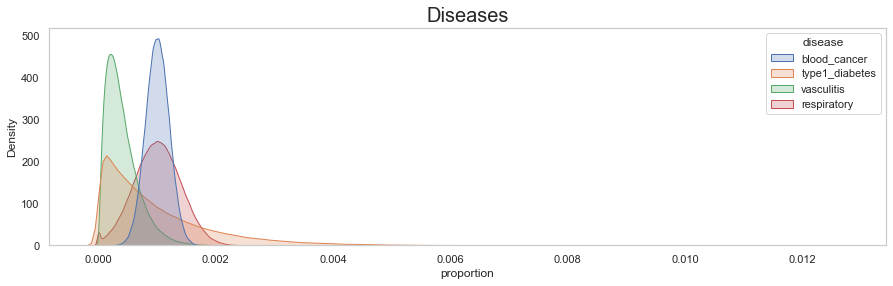

In [9]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df3, x="proportion", hue='disease', bw_adjust=.8, fill=True).set_title("Diseases", size=20)
print('')

# Write data to disk

In [ ]:
# df2.to_csv(os.path.join(data_path, '../medical/fake_medical_data.csv')) # csv takes up 35mb of storage
df2.to_parquet(os.path.join(data_path, '../medical/fake_medical_data.parquet')) # parquet takes up 11.8mb of storage